In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/AML/TestModel/'

/content/drive/MyDrive/AML/TestModel


In [ ]:
# import here
import os
import PIL
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline

---
# Load The Data

In [ ]:
# Load pickled data
training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

# Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [ ]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


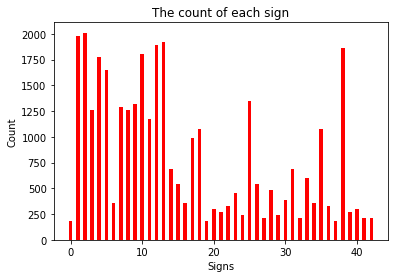

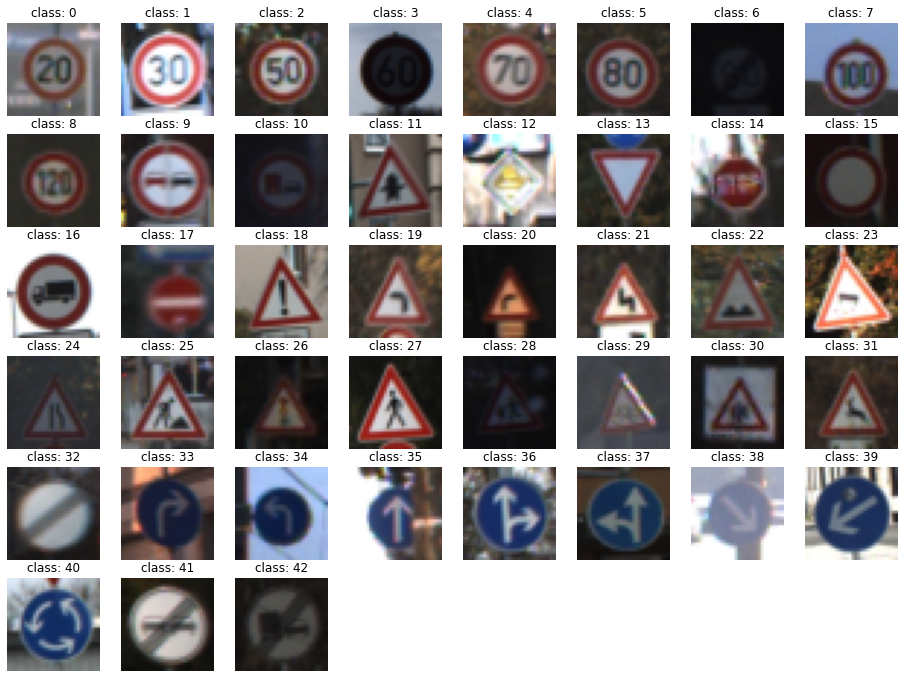

In [ ]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])

----

# Design and Test a Baseline Model Architecture

## Custom Dataset & DataLoader

In [ ]:
class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

In [ ]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

## Baseline Model

In [ ]:
class BaselineNet(nn.Module):
    def __init__(self, gray=False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training

In [ ]:
torch.manual_seed(1)

In [ ]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

train_loader = WrappedDataLoader(train_loader, to_device)
valid_loader = WrappedDataLoader(valid_loader, to_device)
test_loader = WrappedDataLoader(test_loader, to_device)

In [ ]:
model = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20

In [ ]:
BaselineNet()

BaselineNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=43, bias=True)
)

In [ ]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)

In [ ]:
def valid_batch(model, loss_func, x, y,disp):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    if disp==True:
      plt.figure(figsize=(16, 16))
      c=0
      for i in range(len(correct)):
        c+=1
        if c==10:
          break
        if correct[i]==False:
              plt.subplot(8, 8, c+1)
              plt.axis('off')
              plt.title('Original: {} Pred {}'.format(y[i],pred[i]))
              #plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')
              plt.imshow(x[i][0].to('cpu'),cmap='gray')
      plt.show()
    #print(len(pred))
    
    return loss.item(), torch.sum(correct).item(), len(x)

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl,disp):
    train_loss_list=[]
    val_loss_list=[]
    val_acc_list=[]
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        train_loss_list.append(train_loss)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y,disp) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            val_loss_list.append(valid_loss)
            val_acc_list.append(valid_accuracy)
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accuracy: {valid_accuracy:.3f}%")
    return  train_loss_list,val_loss_list,val_acc_list      

In [ ]:
def evaluate(model, loss_func, dl,disp):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y,disp) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [ ]:
tr_loss_list,vl_loss_list,vl_accuracy_list=fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader,False)
evaluate(model, criterion, test_loader,False)

[Epoch 1/20] Train loss: 3.675901	Validation loss: 3.592884	 Validation accuracy: 5.442%
[Epoch 2/20] Train loss: 3.483877	Validation loss: 3.568388	 Validation accuracy: 5.578%
[Epoch 3/20] Train loss: 3.455275	Validation loss: 3.537173	 Validation accuracy: 7.914%
[Epoch 4/20] Train loss: 3.325383	Validation loss: 3.273997	 Validation accuracy: 22.313%
[Epoch 5/20] Train loss: 2.649439	Validation loss: 2.297327	 Validation accuracy: 38.707%
[Epoch 6/20] Train loss: 1.666490	Validation loss: 1.548947	 Validation accuracy: 55.896%
[Epoch 7/20] Train loss: 1.116746	Validation loss: 1.131305	 Validation accuracy: 67.868%
[Epoch 8/20] Train loss: 0.815001	Validation loss: 1.055911	 Validation accuracy: 71.746%
[Epoch 9/20] Train loss: 0.645806	Validation loss: 0.795622	 Validation accuracy: 77.755%
[Epoch 10/20] Train loss: 0.536574	Validation loss: 0.823994	 Validation accuracy: 77.370%
[Epoch 11/20] Train loss: 0.455683	Validation loss: 0.750209	 Validation accuracy: 80.544%
[Epoch 12/2

## Plots for Baseline

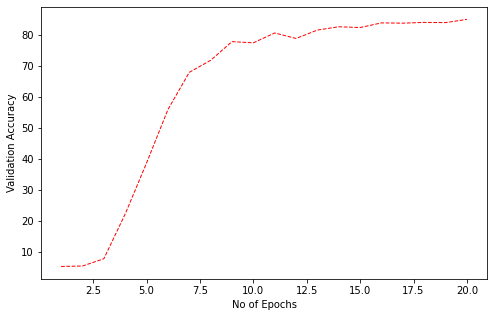

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.asarray([i for i in range(1,21)])

plt.figure(num = 3, figsize=(8, 5))
plt.plot(x, np.asarray(vl_accuracy_list), 
         color='red',   
         linewidth=1.0,  
         linestyle='--' 
        )
plt.xlabel('No of Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

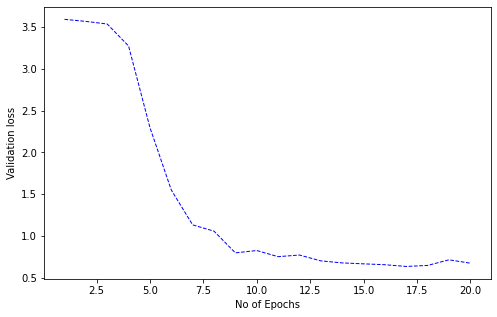

In [ ]:
x = np.asarray([i for i in range(1,21)])

plt.figure(num = 3, figsize=(8, 5))
plt.plot(x, np.asarray(vl_loss_list), 
         color='blue',   
         linewidth=1.0,  
         linestyle='--' 
        )
plt.xlabel('No of Epochs')
plt.ylabel('Validation loss')
plt.show()

---
# Experiment and find tuning

## Data preprocessing

In [ ]:
class CLAHE_GRAY:
    def __init__(self, clipLimit=2.5, tileGridSize=(4, 4)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_y = clahe.apply(img_y)
        img_output = img_y.reshape(img_y.shape + (1,))
        return img_output

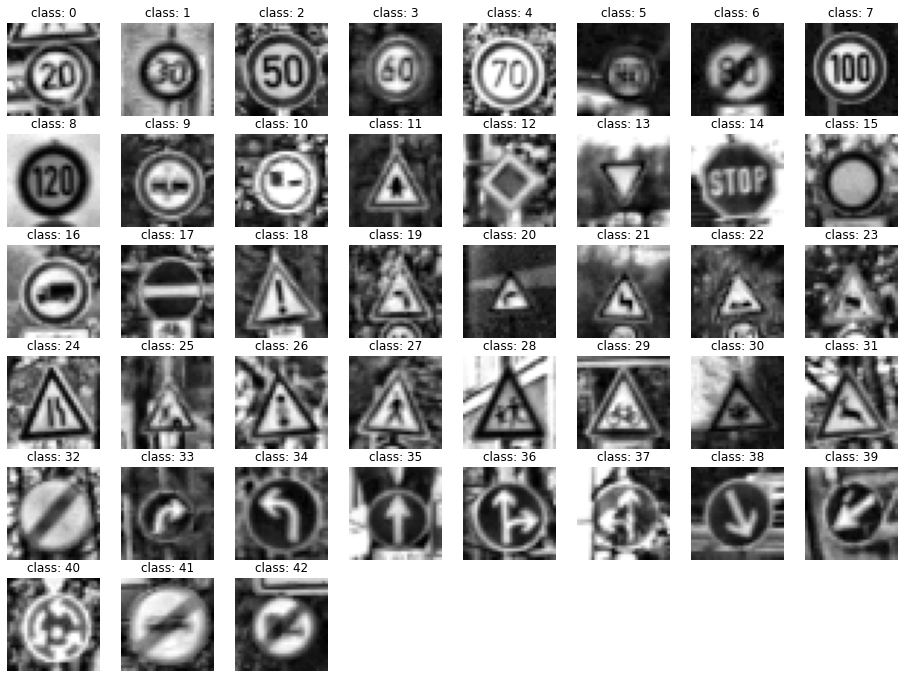

In [ ]:
clahe = CLAHE_GRAY()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')

In [ ]:
data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor()
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

In [ ]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
tr_loss_list,vl_loss_list,vl_accuracy_list=fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader,disp=False)
evaluate(model, criterion, test_loader,disp=False)

[Epoch 1/20] Train loss: 3.662090	Validation loss: 3.562196	 Validation accuracy: 5.442%
[Epoch 2/20] Train loss: 3.475402	Validation loss: 3.548024	 Validation accuracy: 5.556%
[Epoch 3/20] Train loss: 3.458544	Validation loss: 3.528008	 Validation accuracy: 10.930%
[Epoch 4/20] Train loss: 3.387149	Validation loss: 3.362736	 Validation accuracy: 16.984%
[Epoch 5/20] Train loss: 2.757137	Validation loss: 2.220843	 Validation accuracy: 39.365%
[Epoch 6/20] Train loss: 1.567647	Validation loss: 1.494160	 Validation accuracy: 51.746%
[Epoch 7/20] Train loss: 1.011104	Validation loss: 1.030626	 Validation accuracy: 68.526%
[Epoch 8/20] Train loss: 0.767565	Validation loss: 0.871362	 Validation accuracy: 73.628%
[Epoch 9/20] Train loss: 0.621340	Validation loss: 0.642566	 Validation accuracy: 81.610%
[Epoch 10/20] Train loss: 0.520411	Validation loss: 0.622353	 Validation accuracy: 82.766%
[Epoch 11/20] Train loss: 0.454447	Validation loss: 0.586377	 Validation accuracy: 82.063%
[Epoch 12/

## **BaseLine Model Plots(After CLAHE and Gray Scale)**

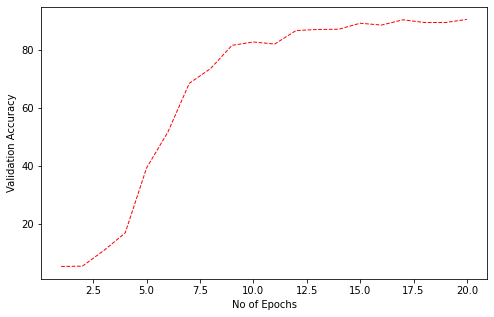

In [ ]:
plt.figure(num = 3, figsize=(8, 5))
plt.plot(x, np.asarray(vl_accuracy_list), 
         color='red',   
         linewidth=1.0,  
         linestyle='--' 
        )
plt.xlabel('No of Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

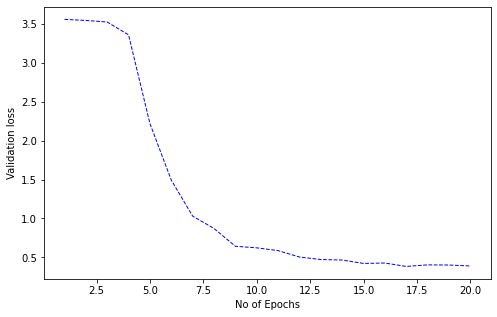

In [ ]:
plt.figure(num = 3, figsize=(8, 5))
plt.plot(x, np.asarray(vl_loss_list), 
         color='blue',   
         linewidth=1.0,  
         linestyle='--' 
        )
plt.xlabel('No of Epochs')
plt.ylabel('Validation loss')
plt.show()

## Save preprocessed images

In [ ]:
def preprocess(path):
    if not os.path.exists(f"{path}/train_gray.p"):
        for dataset in ['train', 'valid', 'test']:
            with open(f"{path}/{dataset}.p", mode='rb') as f:
                data = pickle.load(f)
                X = data['features']
                y = data['labels']

            clahe = CLAHE_GRAY()
            for i in range(len(X)):
                X[i] = clahe(X[i])

            X = X[:, :, :, 0]
            with open(f"{path}/{dataset}_gray.p", "wb") as f:
                pickle.dump({"features": X.reshape(
                    X.shape + (1,)), "labels": y}, f)

In [ ]:
preprocess('data')
training_file = 'data/train_gray.p'
validation_file = "data/valid_gray.p"
testing_file = "data/test_gray.p"

In [ ]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

## Handling imbalanced dataset

### Flipping

In [ ]:
def extend_dataset(dataset):
    X = dataset.features
    y = dataset.labels
    num_classes = 43
    
    X_extended = np.empty([0] + list(dataset.features.shape)[1:], dtype=dataset.features.dtype)
    y_extended = np.empty([0], dtype = dataset.labels.dtype)
    
    horizontally_flippable = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    vertically_flippable = [1, 5, 12, 15, 17]
    both_flippable = [32, 40]
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38]
    ])
    
    for c in range(num_classes):
        X_extended = np.append(X_extended, X[y==c], axis=0)  
        
        if c in horizontally_flippable:
            X_extended = np.append(X_extended, X[y==c][:,:,::-1,:], axis=0)
        if c in vertically_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,:,:], axis=0)
        if c in cross_flippable[:,0]:
            flip_c = cross_flippable[cross_flippable[:,0]==c][0][1]
            X_extended = np.append(X_extended, X[y==flip_c][:,:,::-1,:], axis=0)
        if c in both_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,::-1,:], axis=0)
        
        y_extended = np.append(y_extended, np.full(X_extended.shape[0]-y_extended.shape[0], c, dtype=y_extended.dtype))
    
    dataset.features = X_extended
    dataset.labels = y_extended
    dataset.count = len(y_extended)
    
    return dataset

In [ ]:
train_dataset = extend_dataset(train_dataset)
train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)

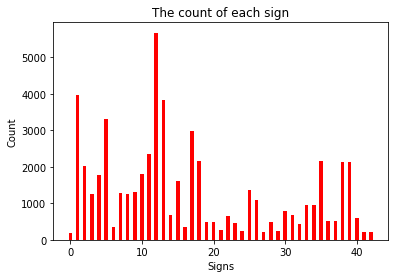

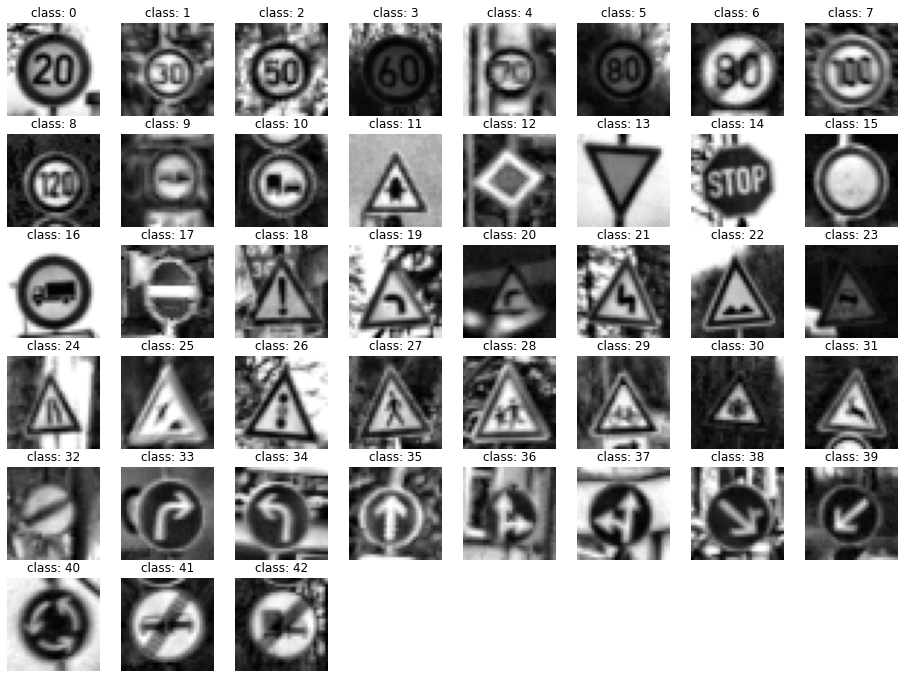

In [ ]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(train_dataset.labels), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(train_dataset.labels == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(train_dataset.features[i].squeeze(), cmap='gray')

In [ ]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader,disp=False)
evaluate(model, criterion, test_loader,disp=False)

[Epoch 1/20] Train loss: 3.622040	Validation loss: 3.640909	 Validation accuracy: 4.762%
[Epoch 2/20] Train loss: 3.395621	Validation loss: 3.616143	 Validation accuracy: 4.762%
[Epoch 3/20] Train loss: 3.262604	Validation loss: 3.193297	 Validation accuracy: 16.100%
[Epoch 4/20] Train loss: 1.954703	Validation loss: 1.564513	 Validation accuracy: 54.739%
[Epoch 5/20] Train loss: 0.996330	Validation loss: 0.993935	 Validation accuracy: 71.814%
[Epoch 6/20] Train loss: 0.680651	Validation loss: 0.792363	 Validation accuracy: 77.052%
[Epoch 7/20] Train loss: 0.505595	Validation loss: 0.657808	 Validation accuracy: 81.406%
[Epoch 8/20] Train loss: 0.400382	Validation loss: 0.550880	 Validation accuracy: 84.354%
[Epoch 9/20] Train loss: 0.324567	Validation loss: 0.550929	 Validation accuracy: 84.444%
[Epoch 10/20] Train loss: 0.271456	Validation loss: 0.498096	 Validation accuracy: 86.349%
[Epoch 11/20] Train loss: 0.230301	Validation loss: 0.448317	 Validation accuracy: 88.027%
[Epoch 12/

### Augmentation

In [ ]:
train_dataset = extend_dataset(PickledDataset(training_file))

class_sample_count = np.bincount(train_dataset.labels)
weights = 1 / np.array([class_sample_count[y] for y in train_dataset.labels])
samp = sampler.WeightedRandomSampler(weights, 43 * 20000)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)

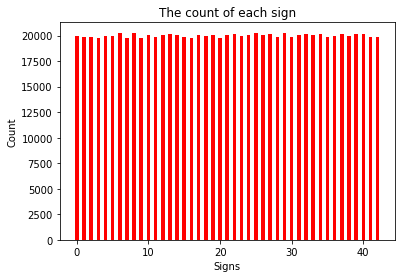

In [ ]:
balanced_y_train = torch.LongTensor([]).to(device)

with torch.no_grad():
    for _, y in train_loader:
        balanced_y_train = torch.cat((balanced_y_train, y))

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balanced_y_train.cpu().numpy()), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

In [ ]:
train_data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomApply([
        transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)
    ]),
    transforms.ToTensor()
])
test_data_transforms = transforms.ToTensor()

train_dataset = extend_dataset(PickledDataset(training_file, transform=train_data_transforms))
valid_dataset = PickledDataset(validation_file, transform=test_data_transforms)
test_dataset = PickledDataset(testing_file, transform=test_data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1298: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1428: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. "


In [ ]:
def convert_image_np(img):
    img = img.numpy().transpose((1, 2, 0)).squeeze()
    return img

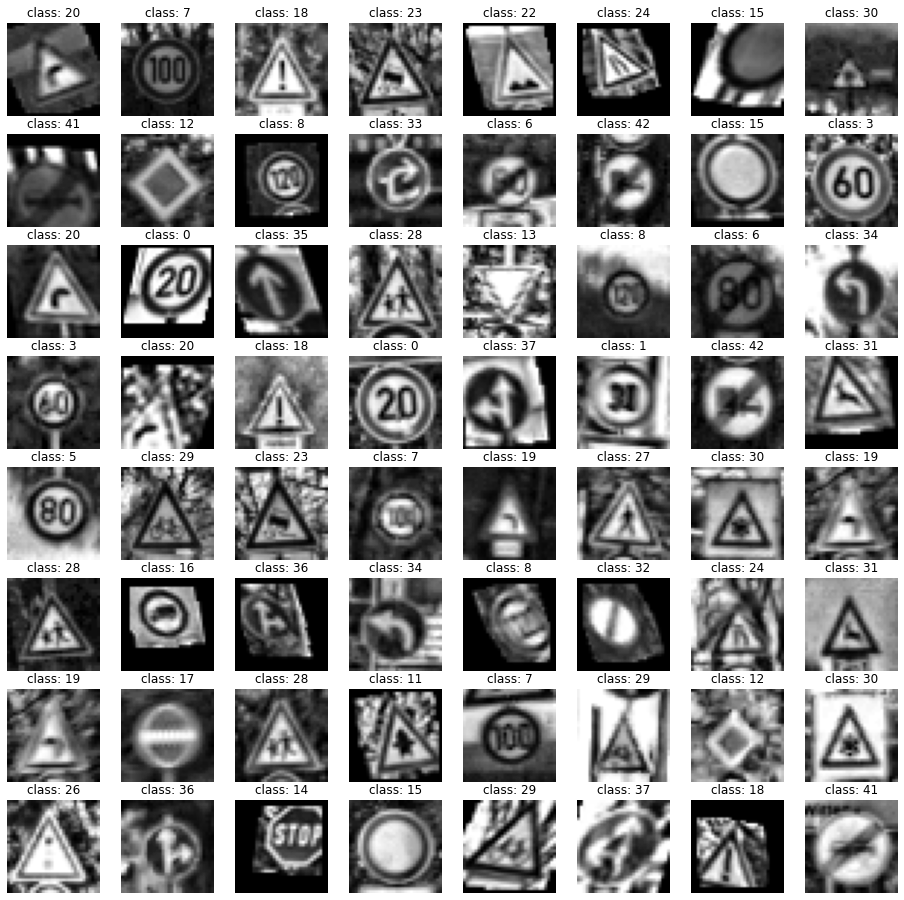

In [ ]:
with torch.no_grad():
    x, y = next(iter(train_loader))
    plt.figure(figsize=(16, 16))
    for i in range(len(y)):
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.title('class: {}'.format(y[i]))
        plt.imshow(convert_image_np(x[i].cpu()), cmap='gray')

In [ ]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
tr_loss_list,vl_loss_list,vl_accuracy_list=fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader,disp=False)
evaluate(model, criterion, test_loader,disp=False)

[Epoch 1/20] Train loss: 2.662814	Validation loss: 0.599818	 Validation accuracy: 81.950%
[Epoch 2/20] Train loss: 0.802543	Validation loss: 0.350924	 Validation accuracy: 90.952%
[Epoch 3/20] Train loss: 0.520575	Validation loss: 0.313264	 Validation accuracy: 91.950%
[Epoch 4/20] Train loss: 0.407867	Validation loss: 0.335196	 Validation accuracy: 92.154%
[Epoch 5/20] Train loss: 0.343254	Validation loss: 0.288734	 Validation accuracy: 92.608%
[Epoch 6/20] Train loss: 0.300216	Validation loss: 0.291884	 Validation accuracy: 93.084%
[Epoch 7/20] Train loss: 0.265597	Validation loss: 0.298839	 Validation accuracy: 92.290%
[Epoch 8/20] Train loss: 0.239801	Validation loss: 0.242928	 Validation accuracy: 93.469%


## Model

In [ ]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        # Constraints for layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride = 1, padding=2)
        self.batch1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2) #default stride is equivalent to the kernel_size
        # Constraints for layer 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride = 1, padding=2)
        self.batch2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        # Defining the Linear layer
        self.fc1 = nn.Linear(2048,1024)
        self.dropout = nn.Dropout(p=0.5)
        # Defining the Linear layer
        self.fc2 = nn.Linear(1024,256)
        self.dropout1 = nn.Dropout(p=0.5)
        # Defining the Linear layer
        self.fc3 = nn.Linear(256,43)

    # defining the network flow
    def forward(self, x):
          # Conv 1
          out = self.conv1(x)
          out = self.batch1(out)
          out = self.relu1(out)
          # Max Pool 1
          out = self.pool1(out)
          # Conv 2
          out = self.conv2(out)
          out = self.batch2(out)
          out = self.relu2(out)
          # Max Pool 2
          out = self.pool2(out)
          out = out.view(out.size(0),-1)
          # Linear Layer
          out = self.fc1(out)
          out=self.dropout(out)
          # Linear layer
          out = self.fc2(out)
          out=self.dropout1(out)
          # Linear layer
          out = self.fc3(out)
          return out

In [ ]:
TrafficSignNet()

TrafficSignNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=43, bias=True)
)

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, patience=10):
    wait = 0
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y,disp=False) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return

In [ ]:
n_epochs = 20
cnn_model1= TrafficSignNet().to(device)
optimizer = optim.Adam(cnn_model1.parameters(), lr=0.001)
fit(n_epochs, cnn_model1, criterion, optimizer, train_loader, valid_loader)

[Epoch 1/20] Train loss: 0.417258	Validation loss: 0.157938	 Validation accruacy: 96.599%
Validation loss decreased (inf --> 0.157938). Saving model...
[Epoch 2/20] Train loss: 0.172669	Validation loss: 0.098514	 Validation accruacy: 97.642%
Validation loss decreased (0.157938 --> 0.098514). Saving model...
[Epoch 3/20] Train loss: 0.148791	Validation loss: 0.107337	 Validation accruacy: 97.234%
[Epoch 4/20] Train loss: 0.139267	Validation loss: 0.083028	 Validation accruacy: 97.755%
Validation loss decreased (0.098514 --> 0.083028). Saving model...
[Epoch 5/20] Train loss: 0.130420	Validation loss: 0.154050	 Validation accruacy: 97.664%
[Epoch 6/20] Train loss: 0.125920	Validation loss: 0.214661	 Validation accruacy: 96.417%
[Epoch 7/20] Train loss: 0.120970	Validation loss: 0.155460	 Validation accruacy: 97.460%
[Epoch 8/20] Train loss: 0.117071	Validation loss: 0.179531	 Validation accruacy: 97.528%
[Epoch 9/20] Train loss: 0.114151	Validation loss: 0.157908	 Validation accruacy: 97

In [ ]:
torch.save(cnn_model1.state_dict(), 'CNN_model1.pt')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

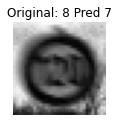

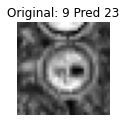

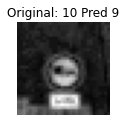

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

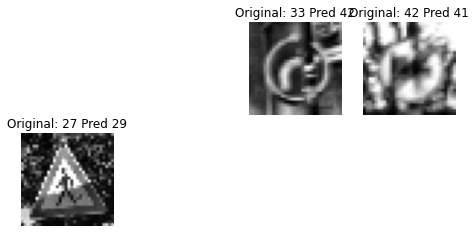

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

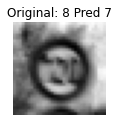

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

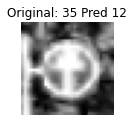

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

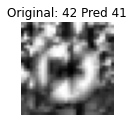

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

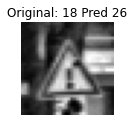

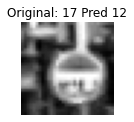

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

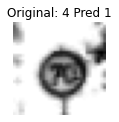

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

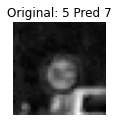

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

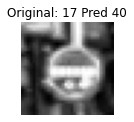

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

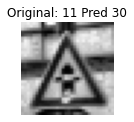

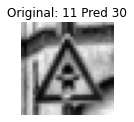

<Figure size 1152x1152 with 0 Axes>

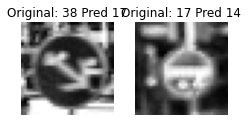

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

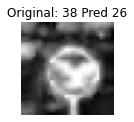

<Figure size 1152x1152 with 0 Axes>

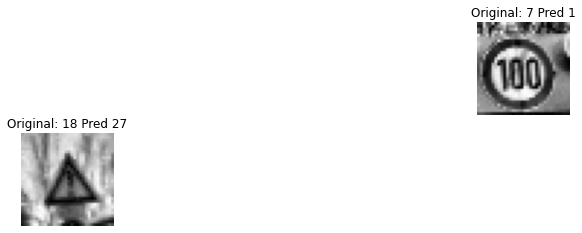

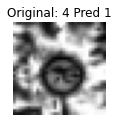

<Figure size 1152x1152 with 0 Axes>

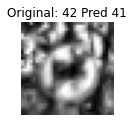

<Figure size 1152x1152 with 0 Axes>

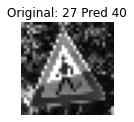

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

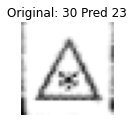

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

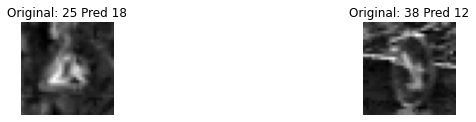

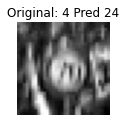

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

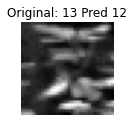

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

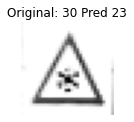

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

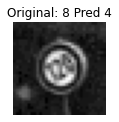

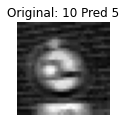

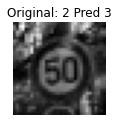

<Figure size 1152x1152 with 0 Axes>

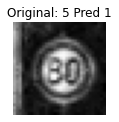

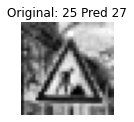

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

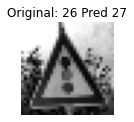

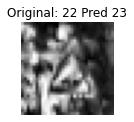

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

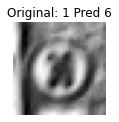

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

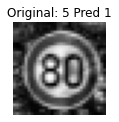

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

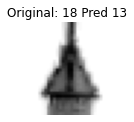

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

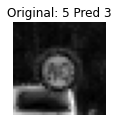

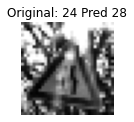

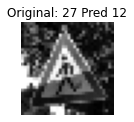

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

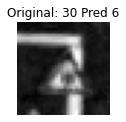

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

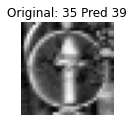

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

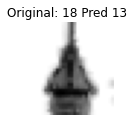

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

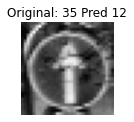

<Figure size 1152x1152 with 0 Axes>

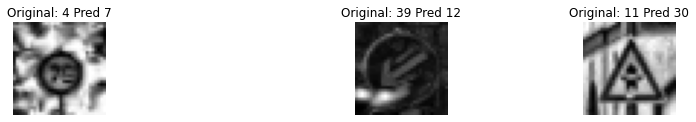

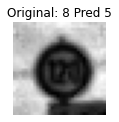

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

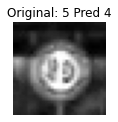

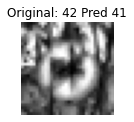

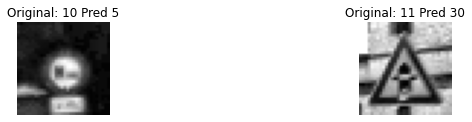

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

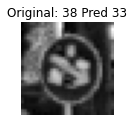

<Figure size 1152x1152 with 0 Axes>

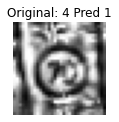

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

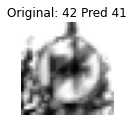

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

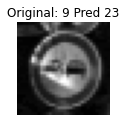

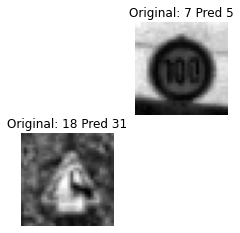

Test loss: 0.240160	Test accruacy: 96.239%


In [ ]:
cnn_model1= TrafficSignNet().to(device)
check_point = torch.load('CNN_model1.pt', map_location=device)
criterion = nn.CrossEntropyLoss()
cnn_model1.load_state_dict(check_point)
evaluate(cnn_model1, criterion, test_loader,disp=True)


In [ ]:
evaluate(cnn_model1, criterion, test_loader,disp=False)

Test loss: 0.240150	Test accruacy: 96.239%


**Confusion Matrix**

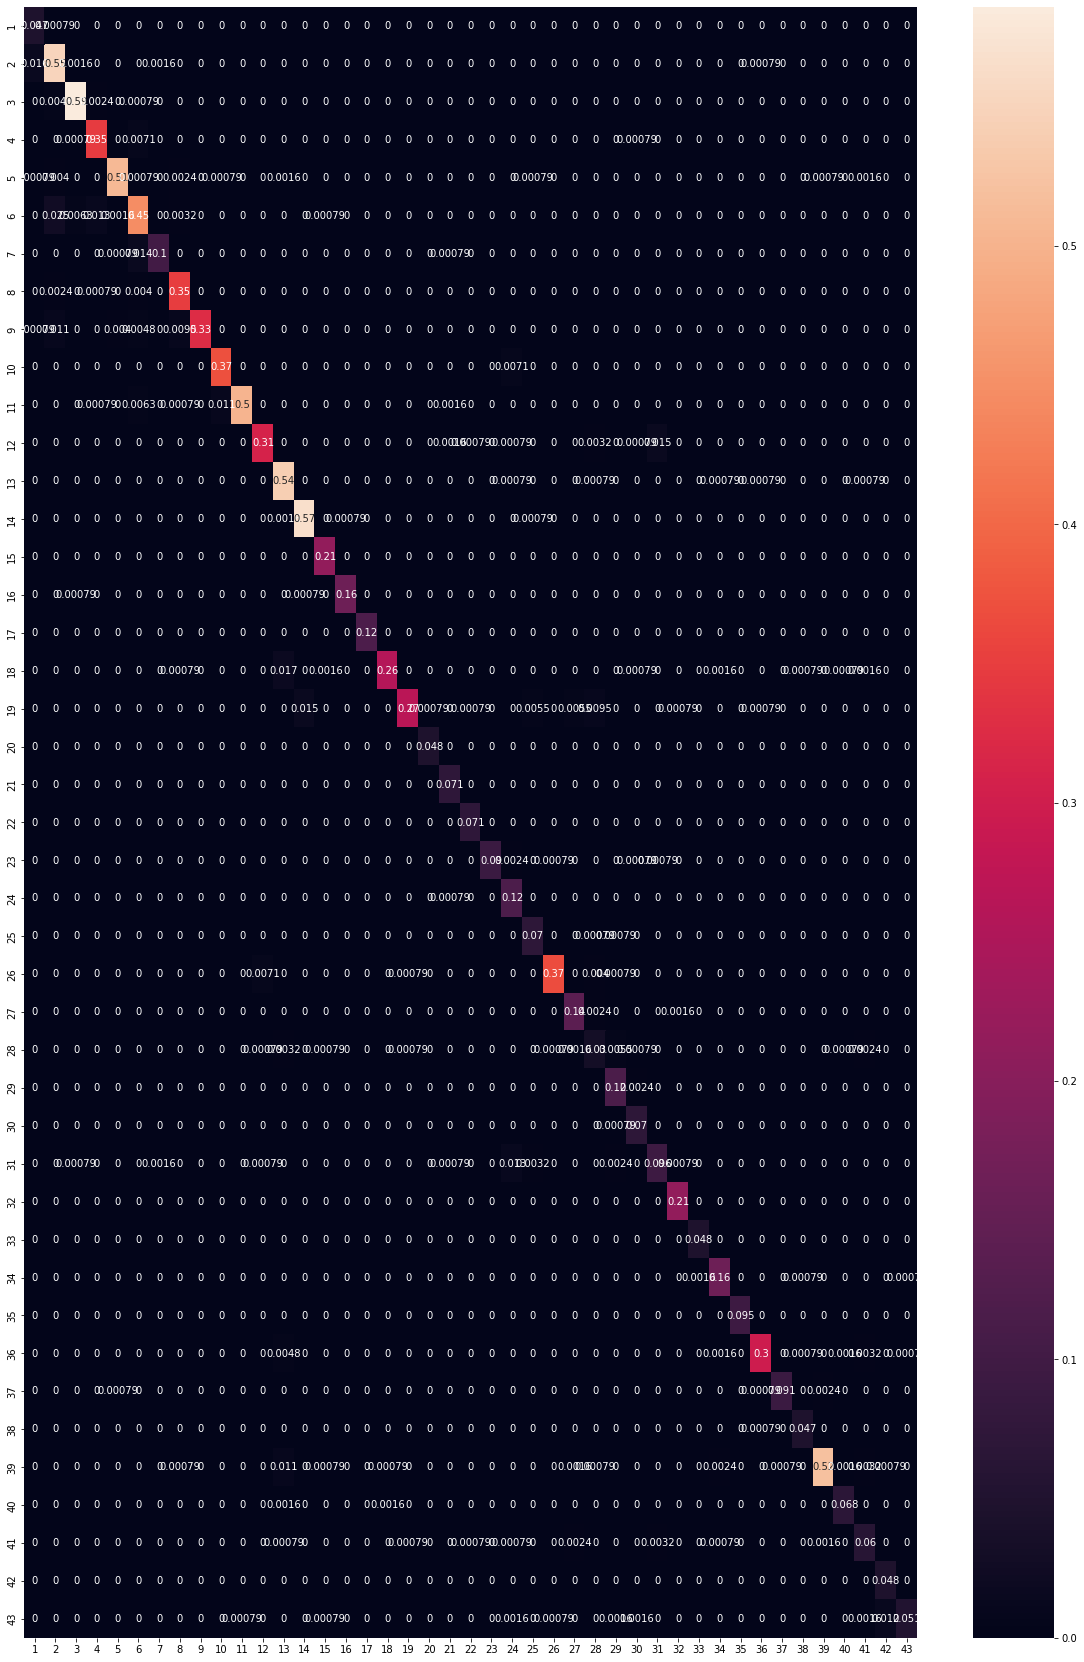

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = cnn_model1(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39','40','41','42','43')
# Build confusion matrix
cf_matrix = confusion_matrix(y_true[:], y_pred[:])
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,30))
sn.heatmap(df_cm, annot=True)

## Future Work
### Improving the accuracy of the model using Spatial Transformer networks
